In [121]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [122]:
# Normalizing our data
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [123]:
# Preparing lables via one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


In [124]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enhanced Data Augmentation with more variations
datagen = ImageDataGenerator(
    rotation_range=30,          # Increase rotation
    vertical_flip=True,         # Adds vertical rotation
    width_shift_range=0.3,      # Increase horizontal shift
    height_shift_range=0.3,     # Increase vertical shift
    horizontal_flip=True,       # Allow flips
    zoom_range=0.2,             # Add zooming
    brightness_range=[0.7, 1.3], # Increase brightness adjustment range
    shear_range=0.2             # Add shear transformations
)

# Apply the augmentation
datagen.fit(x_train)  # Ensure x_train is used with augmented batches during training



In [126]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, SeparableConv2D, GlobalAveragePooling2D, Activation

model = Sequential()

# First convolutional block
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-4), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
    
# Second convolutional block
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
    
# Third convolutional block
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
    
# Dense layers
model.add(Flatten())
model.add(Dense(512, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [127]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0

In [128]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

# Define the ReduceLROnPlateau callback
lr_reduction = ReduceLROnPlateau(monitor='val_loss',   # Monitor validation loss
                                 patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
                                 factor=0.5,           # Factor by which the learning rate will be reduced. New_lr = lr * factor
                                 min_lr=1e-6)          # Lower bound on the learning rate


In [129]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights to adjust the loss function based on the training data
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train.argmax(axis=1)),
                                     y=y_train.argmax(axis=1))

# Convert to dictionary format for Keras
class_weights_dict = dict(enumerate(class_weights))


In [131]:
cifar_trained = model.fit(x_train, y_train, batch_size=256, epochs=50, validation_data=(x_test, y_test),class_weight=class_weights_dict, callbacks=[lr_reduction])

Epoch 1/50


2024-09-25 15:43:05.947198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


196/196 [==============================] - 15s 47ms/step - loss: 1.8788 - accuracy: 0.4501 - val_loss: 1.9021 - val_accuracy: 0.4548 - lr: 0.0010
Epoch 2/50
196/196 [==============================] - 7s 38ms/step - loss: 1.3421 - accuracy: 0.6310 - val_loss: 1.4692 - val_accuracy: 0.5947 - lr: 0.0010
Epoch 3/50
196/196 [==============================] - 7s 38ms/step - loss: 1.1242 - accuracy: 0.7105 - val_loss: 1.1249 - val_accuracy: 0.7126 - lr: 0.0010
Epoch 4/50
196/196 [==============================] - 7s 38ms/step - loss: 1.0075 - accuracy: 0.7504 - val_loss: 1.0207 - val_accuracy: 0.7468 - lr: 0.0010
Epoch 5/50
196/196 [==============================] - 7s 38ms/step - loss: 0.9275 - accuracy: 0.7798 - val_loss: 0.9064 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 6/50
196/196 [==============================] - 8s 39ms/step - loss: 0.8635 - accuracy: 0.8021 - val_loss: 0.8726 - val_accuracy: 0.7977 - lr: 0.0010
Epoch 7/50
196/196 [==============================] - 7s 38ms/step - loss:

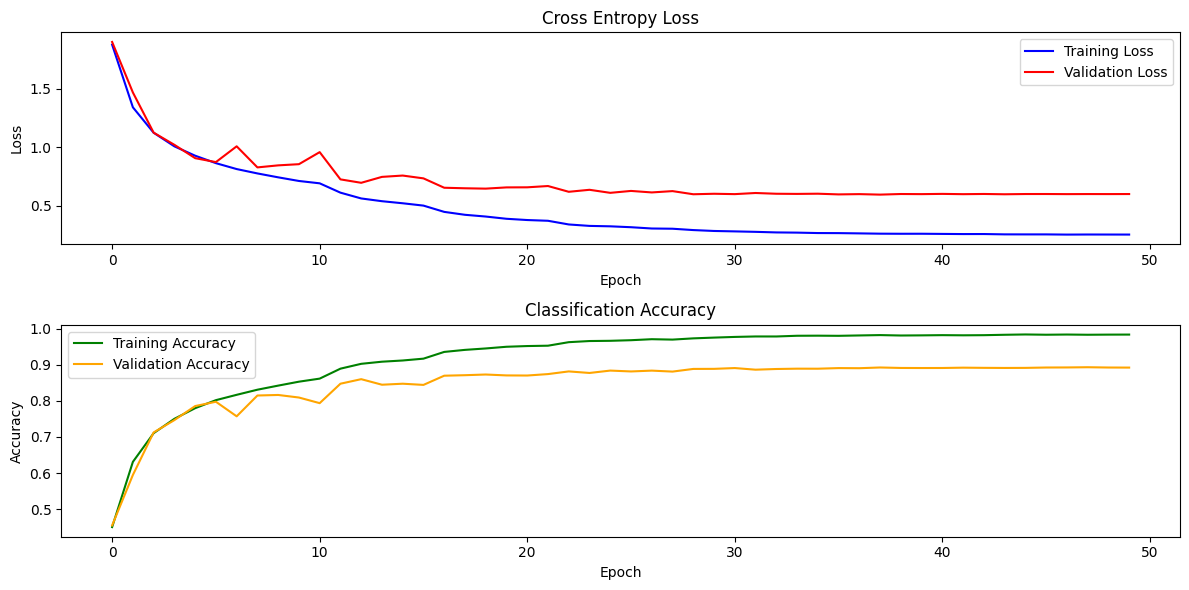

In [132]:
# Plotting the Cross Entropy Loss and Classification Accuracy
plt.figure(figsize=(12, 6))

# Plot Cross Entropy Loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(cifar_trained.history['loss'], color='blue', label='Training Loss')
plt.plot(cifar_trained.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Classification Accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(cifar_trained.history['accuracy'], color='green', label='Training Accuracy')
plt.plot(cifar_trained.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


313/313 [==============================] - 1s 2ms/step


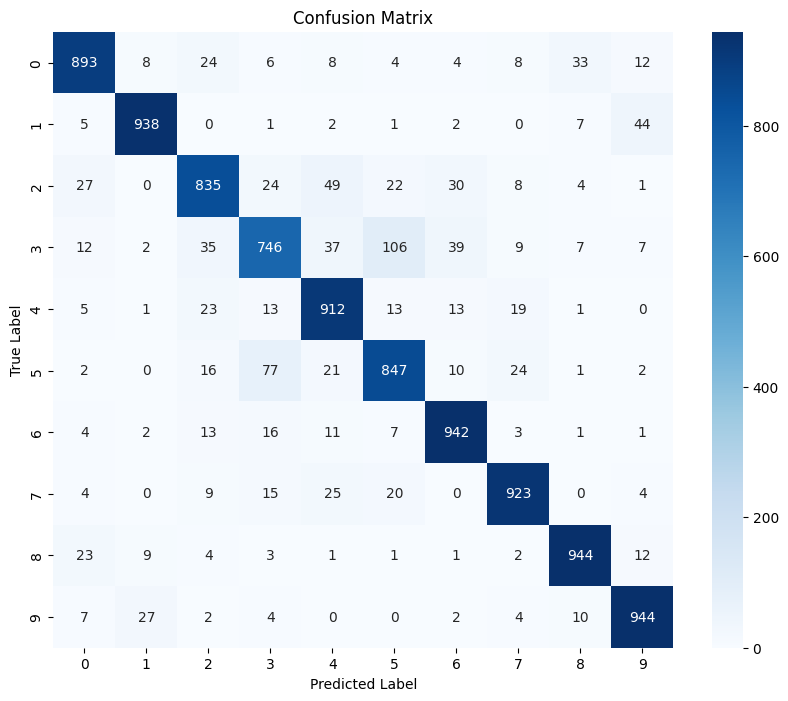

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions and true labels
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
gt = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(gt, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [134]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.5989 - accuracy: 0.8924
Test loss: 0.598854124546051
Test accuracy: 0.8924000263214111


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


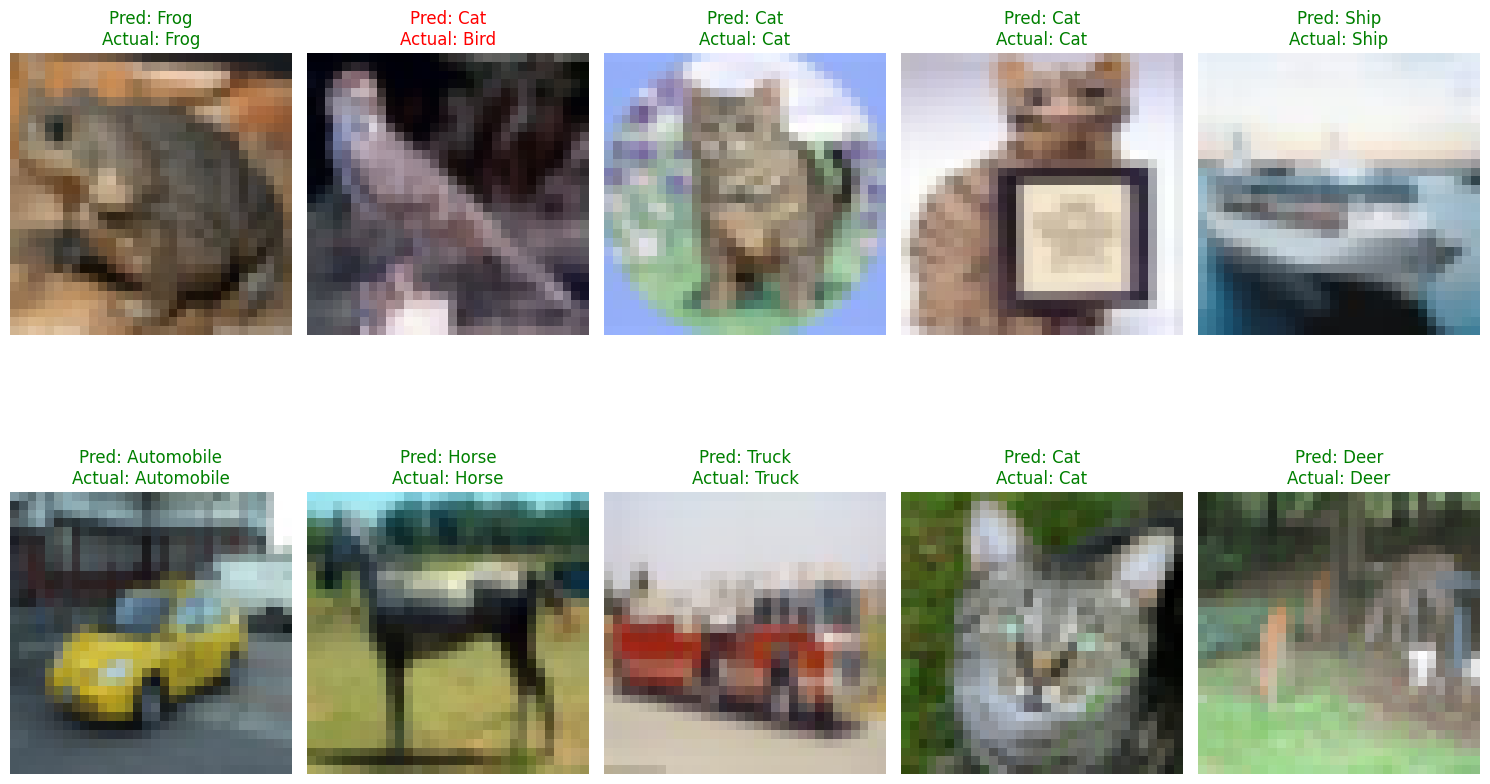

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Class names for CIFAR-10
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Function to display random images with their predictions and actual labels
def display_random_predictions(x_test, y_test, model, class_names):
    # Select 10 random indices from the test set
    random_indices = random.sample(range(x_test.shape[0]), 10)
    
    # Create a figure for plotting
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(random_indices):
        # Get the actual image and label
        image = x_test[idx]
        actual_label = np.argmax(y_test[idx])
        
        # Predict the class of the image
        prediction = model.predict(np.expand_dims(image, axis=0))  # Expand dimensions to match model input
        predicted_label = np.argmax(prediction[0])
        
        # Plot the image
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')
        
        # Set the title with predicted and actual labels
        title_color = 'green' if predicted_label == actual_label else 'red'  # Green if correct, red if incorrect
        plt.title(f"Pred: {class_names[predicted_label]}\nActual: {class_names[actual_label]}", color=title_color)
    
    plt.tight_layout()
    plt.show()

# Call the function to display the images
display_random_predictions(x_test, y_test, model, class_names)

In [136]:
from keras.backend import clear_session
clear_session()